CNN para Detecção/Diagnóstico de Falhas
--------------------------------------------------------


O objetivo do trabalho é usar os sinais produzidos pelo simulador do Tennessee Eastman (TE)
para detectar uma falha e/ou diagnosticar qual falha ocorreu


Dados: Os arquivos pré-divididos 'd00.dat, d00_te.dat', ..., 'd21.dat d21_te.dat'


00 = Normalidade

xx = Falha xx


xx.dat (exceto 00.dat) contém dados da falha

xx_te.dat contém 160 amostras de normalidade, depois o resto da falha


O arquivo TE.py já contém muita funcionalidade necessária (ler arquivo, visualizar sinal, ...)





Deve usar uma rede CNN para montar o sistema.


Avaliação por validação cruzada 5-fold.

In [66]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import models, layers, losses, regularizers, callbacks
from sklearn.metrics import accuracy_score

In [2]:
def normalize(d):
  media_treino = d.mean(axis=0)
  std_treino = d.std(axis=0, ddof=0)
  d = d - media_treino
  d = d/std_treino
  return d

def get_entradas_labels_treino(dados_normais, falha_treino, colunas):

  # seleciona e lê o i-ésimo arquivo de falha   
  dfalha_i = pd.read_csv(falha_treino, delim_whitespace=True, header=None)
  dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1
  # concatena os dados normais com os dados de falha
  dtreino = pd.concat([dados_normais, dfalha_i]) 
  X = dtreino[colunas].values
  labels_treino = dtreino['falha'].values
  # shape (X, 13, 2, 2) de acordo o padrão esperado por uma cnn
  X = X.reshape(len(X), 13, 2, 2)
  labels_treino = labels_treino.reshape(len(labels_treino), 1)
  # normaliza os dados de treino
  X = normalize(X)
  
  return X, labels_treino

def get_entradas_labels_teste(falha_treino, colunas):
  ### dados de teste
  dte = pd.read_csv(falha_treino, delim_whitespace=True, header=None)
  dte['falha'] = np.ones(len(dte), dtype='int')*1
  # primeiros 160 são dados de normalidade
  dte.loc[np.arange(160), 'falha'] = 0

  X_teste = dte[colunas].values
  labels_teste = dte['falha'].values
  # apenas para manter o padrão entre 0 e 1
  labels_teste = labels_teste/np.max(labels_teste)
  X_teste = normalize(X_teste)
  X_teste = X_teste.reshape(len(X_teste), 13, 2, 2)
  return X_teste, labels_teste

def plot_falha(falha_treino):
  dfalha_i = pd.read_csv(falha_treino, delim_whitespace=True, header=None)
  dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1
  dfalha_i[[0,1,2]].plot()

In [3]:
# todos os arquivos
arquivos = glob.glob('data/*.dat')
# arquivos de teste
arquivos_teste = glob.glob('data/*te.dat')
# arquivos de treino (falha)
arquivos_treino = sorted(list(set(arquivos).difference(arquivos_teste)))

In [19]:
dfalha_i = pd.read_csv(arquivos_treino[3], delim_whitespace=True, header=None)
dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1

In [20]:
dfalha_i

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,falha
0,0.25695,3637.2,4483.4,9.2595,27.269,42.631,2705.0,74.757,120.42,0.33301,80.183,48.265,2633.5,26.132,48.587,3103.0,23.262,65.783,231.55,340.83,94.607,77.584,32.303,8.8775,26.709,6.8919,18.499,1.6858,33.316,13.940,24.119,1.3400,18.520,2.2422,4.9278,2.2223,0.037789,0.84539,0.088573,53.671,44.050,62.666,54.145,25.103,59.943,22.151,40.462,32.993,43.265,47.468,41.579,17.360,1
1,0.25631,3628.1,4487.2,9.4093,27.066,42.481,2705.3,74.109,120.38,0.33615,80.242,50.718,2633.2,26.730,50.372,3104.8,23.348,65.786,230.70,340.89,94.593,77.465,32.303,8.8775,26.709,6.8919,18.499,1.6858,33.316,13.940,24.119,1.3400,18.520,2.2422,4.9278,2.2223,0.037789,0.84539,0.088573,53.671,44.050,62.822,54.100,25.166,60.315,21.874,40.080,40.213,47.394,47.456,41.154,17.148,1
2,0.24184,3655.4,4532.0,9.2949,26.564,42.131,2704.4,74.392,120.39,0.34982,80.192,49.208,2632.9,26.052,48.867,3103.1,22.256,65.833,229.24,340.63,94.612,77.252,32.300,8.7861,26.175,7.0059,19.051,1.6642,33.009,13.932,23.707,1.2926,18.621,2.2119,4.9390,2.3017,0.037789,0.84539,0.088573,53.671,44.050,63.037,54.502,23.737,63.233,21.665,42.046,35.770,43.911,47.502,41.012,19.756,1
3,0.24245,3620.1,4587.6,9.3065,27.085,42.144,2702.8,74.089,120.38,0.35163,80.012,50.725,2630.4,25.524,50.108,3101.0,22.910,65.746,228.90,340.77,94.639,76.957,32.300,8.7861,26.175,7.0059,19.051,1.6642,33.009,13.932,23.707,1.2926,18.621,2.2119,4.9390,2.3017,0.037789,0.84539,0.088573,53.671,44.050,63.643,53.836,23.678,58.870,21.931,41.826,40.233,46.783,47.450,40.957,18.238,1
4,0.23874,3650.5,4447.4,9.3846,26.865,41.908,2702.6,74.570,120.40,0.34841,80.018,48.035,2631.8,25.948,48.981,3098.2,23.810,65.709,228.82,341.32,94.659,77.235,31.908,8.9827,26.571,6.6874,18.609,1.6712,32.743,13.756,24.035,1.1664,18.795,2.2464,4.8649,2.3592,0.037789,0.84539,0.088573,53.671,44.050,62.056,54.162,23.879,59.115,22.520,42.166,32.317,44.176,47.377,40.996,16.093,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.26977,3677.2,4504.6,9.3339,26.710,42.340,2705.8,74.810,120.40,0.33011,80.298,51.107,2633.6,25.056,49.321,3104.0,22.640,65.492,222.07,340.60,94.557,77.205,32.208,8.8086,26.235,6.8408,18.677,1.6480,32.813,13.788,23.941,1.1918,18.567,2.2760,4.9111,2.3224,0.019808,0.83169,0.099515,53.587,44.267,63.174,54.230,26.998,58.988,21.654,39.244,41.359,44.964,45.265,41.102,18.791,1
476,0.24166,3692.9,4558.1,9.3008,27.051,42.026,2705.1,75.374,120.43,0.33208,80.211,49.241,2633.8,27.325,48.026,3103.1,22.704,65.494,221.55,340.18,94.567,77.479,32.014,8.8971,26.922,6.7940,18.912,1.6629,32.702,13.835,24.042,1.3615,19.062,2.2787,4.9130,2.3407,0.019808,0.83169,0.099515,53.587,44.267,63.279,53.476,23.595,64.254,21.877,40.637,35.865,41.966,45.362,41.311,18.624,1
477,0.24255,3654.3,4516.6,9.2815,26.928,42.957,2703.6,74.615,120.41,0.33954,80.120,50.741,2631.0,24.316,47.691,3103.9,23.174,65.468,221.58,340.12,94.547,77.396,32.014,8.8971,26.922,6.7940,18.912,1.6629,32.702,13.835,24.042,1.3615,19.062,2.2787,4.9130,2.3407,0.019808,0.83169,0.099515,53.587,44.267,63.943,53.972,23.508,62.135,21.597,39.727,40.280,41.190,45.413,40.529,17.520,1
478,0.25820,3714.5,4456.7,9.3978,26.921,42.146,2703.2,74.995,120.41,0.34041,80.115,50.291,2632.2,27.251,49.939,3103.2,23.385,65.450,221.55,340.59,94.498,77.139,31.821,8.8635,26.706,6.8445,18.717,1.6689,32.711,13.567,24.410,1.4504,18.626,2.2483,4.8227,2.2604,0.019808,0.83169,0.099515,53.587,44.267,63.380,54.108,25.825,59.071,21.951,40.864,38.955,46.392,45.470,41.793,17.049,1


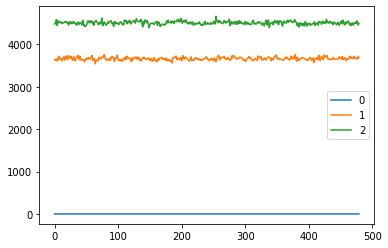

In [18]:
plot_falha(arquivos_treino[3])

In [62]:
def define_model(dropouts=[], r=1):
    """
    TODO: Ver como reduzir o overfitting do modelo
    """
    # definição da CNN
    m  = models.Sequential()
    # Convolutional layer com 32 neurônios
    m.add(layers.Conv2D(int(32/r), (2, 2), activation='relu', input_shape=(13, 2, 2), name='conv1', kernel_regularizer=regularizers.l2(0.01)))
    m.add(layers.MaxPooling2D((2, 1)))
    if dropouts[0]:
        m.add(layers.Dropout(0.4))
    m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv2', kernel_regularizer=regularizers.l2(0.01)))
    m.add(layers.MaxPooling2D((2, 1)))
    if dropouts[1]:
        m.add(layers.Dropout(0.4))
    m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv3', kernel_regularizer=regularizers.l2(0.01)))
    m.add(layers.Flatten())
    m.add(layers.Dense(int(8/r), activation='relu'))
    if dropouts[2]:
        m.add(layers.Dropout(0.2))
    # 21 classes: normal (0) e falha (XX)
    m.add(layers.Dense(2))
    m.compile(optimizer='Adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return m

In [5]:
dnormal = pd.read_csv("data/d00.dat", delim_whitespace=True, header=None)
dnormal['falha'] = np.zeros(len(dnormal), dtype='int')
colunas = np.arange(52)

In [ ]:
dnormal = pd.read_csv("data/d00.dat", delim_whitespace=True, header=None)
dnormal['falha'] = np.zeros(len(dnormal), dtype='int')
colunas = np.arange(52)
acuracias = []
# percorre arquivos de treino com falha (exceto 00.dat, que é de normalidade)
for i in range(1,len(arquivos_treino)):
  modelo.compile(optimizer='Adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  
  
  print ("Treinando modelo - falha {}".format(i))
  history = modelo.fit(X, labels, epochs=15, verbose=0)
  modelo.save("CNN_{}.tf".format(i)) # salva modelo treinado

  
  print ("Classificando dados de teste")
  pred = modelo.predict(X_teste, verbose=0)
  labels_pred = np.argmax(pred, axis=1)
  acc = accuracy_score(labels_pred, labels_teste)
  acuracias.append(acc)
  tf.keras.backend.clear_session()

## Falha 3

In [6]:
X_treino, labels_treino = get_entradas_labels_treino(dnormal, arquivos_treino[3], colunas)

In [55]:
X_treino.shape

(980, 13, 2, 2)

In [74]:
cnn = define_model(dropouts=[1, 0, 1], r=1)

In [72]:
loss_monitor = callbacks.EarlyStopping(monitor='loss')

In [75]:
hist = cnn.fit(X_treino, labels_treino, batch_size=64, verbose=1, epochs=200, callbacks=[loss_monitor])

Epoch 1/200
16/16 [==============================] - 0s 5ms/step - loss: 1.6960 - accuracy: 0.4939
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 1.4634 - accuracy: 0.4980


In [9]:
X_teste, labels_teste = get_entradas_labels_teste(arquivos_teste[3], colunas)

In [76]:
labels_pred = np.argmax(cnn.predict(X_teste), axis=1)
accuracy_score(labels_pred, labels_teste)

30/30 [==============================] - 0s 2ms/step


0.74375

In [30]:
lnorm=[1, 0, 0]

In [32]:
if lnorm[0]:
    print ("Sim")

Sim
